In [ ]:
#hide
!nvidia-smi

Tue Jan 19 13:31:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   27C    P8     9W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#hide
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops axial_positional_embedding wandb
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#all_slow

# enwik8 - baseline

In [ ]:
from fastai.text.all import *
from reformer_fastai.all import *

## Experiment Tracking

Make sure you have wandb and are logged in.

In [ ]:
#hide
# !wandb login

Load Experiment Tracking with Weights & Biases:

In [ ]:
import wandb
from reformer_fastai.tracking import WandbCallback

WANDB_NAME = 'lm_enwik8_base_af'
GROUP = 'TEST'
NOTES = 'Baseline Transformer LM on enwik8 sl 4096'
CONFIG = {}
TAGS =['lm','test','enwik8']

In [ ]:
# wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
#            name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) # config=CONFIG,

## Download and Unpack enwik8 Data

Download and unzip enwik8 data

In [ ]:
path = untar_data('http://mattmahoney.net/dc/enwik8.zip', dest='/data')

## Prepare Data

In [ ]:
df = pd.DataFrame({'text':read_lines(path)})
df.head()

,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


In [ ]:
btt = ByteTextTokenizer(is_lm=True, add_bos=False, add_eos=False)

In [ ]:
%%time
df['toks'] = df['text'].apply(btt)
df['lens'] = df['toks'].apply(len)
df['lens_cum_sum'] = df.lens.cumsum()

CPU times: user 2min 24s, sys: 2.93 s, total: 2min 27s
Wall time: 2min 26s


In [ ]:
train_cutoff = df.lens.sum() - 10_000_000  # keep all but 10M characters for val and test
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

In [ ]:
%%time
tfms = [attrgetter("text"), btt]
dsets = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

CPU times: user 1.1 s, sys: 40.1 ms, total: 1.14 s
Wall time: 1.14 s


In [ ]:
%%time
bs, sl = 2, 4096
# pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])
dl_kwargs = [{'lens':df['lens'].values[train_idxs]},
             {'val_lens':df['lens'].values[validation_idxs]}]
dls = dsets.dataloaders(bs=bs, val_bs=2*bs, seq_len=sl, dl_kwargs=dl_kwargs, shuffle_train=True, n_workers=2)

CPU times: user 31.9 s, sys: 1.19 s, total: 33.1 s
Wall time: 32.7 s


In [ ]:
#collapse_output
dls.show_batch(max_n=4)

,text,text_
0,"== External links ==\n <revision>\n* [http://www.muzarp.poznan.pl/archweb/gazociag/title5.htm &quot;The Goths in Greater Poland&quot; by Tadeusz Makiewicz]\n\n <username>RuM</username>\n*Audio interview on [[Australian]] radio station [[JJJ]], on [[January 26]], [[2006]] : [http://www.abc.net.au/triplej/jayandthedoctor/listen/mp3s/henrirollins.mp3 MP3 Link].\n[[Category:Obsolete list of encyclopedia topics]]</text>\n&lt;/tr&gt;\n\n[[Category:Sibling duos|Ertegun brothers]]\nIn [[1920]], Russell travelled to [[Russia]] as part of an official delegation sent by the British government to investigate the effects of the [[Russian Revolution of 1917|Russian Revolution]]. Russell's lover [[Dora Black]] also visited Russia independently at the same time - she was enthusiastic about the revolution, but Russell's experiences destroyed his previous tentative support for it.\n* [[kaffir lime]] leaves\nThe Commission negotiates international [[trade]] agreements (in the [[World Trade Organization]]) and other international agreements on behalf of the EU. It closely co-operates in this with the [[Council of the European Union]].\n <page>\nSpink, Walter M. “The Achievement of Ajanta,” ''The Age of the Vakatakas'', ed. Shastri,","= External links ==\n <revision>\n* [http://www.muzarp.poznan.pl/archweb/gazociag/title5.htm &quot;The Goths in Greater Poland&quot; by Tadeusz Makiewicz]\n\n <username>RuM</username>\n*Audio interview on [[Australian]] radio station [[JJJ]], on [[January 26]], [[2006]] : [http://www.abc.net.au/triplej/jayandthedoctor/listen/mp3s/henrirollins.mp3 MP3 Link].\n[[Category:Obsolete list of encyclopedia topics]]</text>\n&lt;/tr&gt;\n\n[[Category:Sibling duos|Ertegun brothers]]\nIn [[1920]], Russell travelled to [[Russia]] as part of an official delegation sent by the British government to investigate the effects of the [[Russian Revolution of 1917|Russian Revolution]]. Russell's lover [[Dora Black]] also visited Russia independently at the same time - she was enthusiastic about the revolution, but Russell's experiences destroyed his previous tentative support for it.\n* [[kaffir lime]] leaves\nThe Commission negotiates international [[trade]] agreements (in the [[World Trade Organization]]) and other international agreements on behalf of the EU. It closely co-operates in this with the [[Council of the European Union]].\n <page>\nSpink, Walter M. “The Achievement of Ajanta,” ''The Age of the Vakatakas'', ed. Shastri,"
1,"found in Obadiah 10-21 which [[Book of Jeremiah|Jeremiah]] does not quote, and which, had he had it laid out before him, would have suited his purpose admirably. Despite everything, however, there are a number scholars who support both dates and even some who support dates other than the two major possibilities presented. Therefore, any date for the composition Obadiah must be held tentatively.\n\n\n\n <revision>\n <id>8092</id>\n <id>41285331</id>\n\n\n|input = Two 4-panel [[dance pad]]s, six buttons\nThe term '''blue biotechnology''' has also been used to describe the marine and aquatic applications of biotechnology, but its use is relatively rare.\n[[Category:Armed leftist groups]]\n| bgcolor=&quot;#ffd000&quot; | [[Fermium|Fm]]&lt;br/&gt;1.3\n[[Image:columnchromatography.gif|thumb|right|400px|A picture of a standard column chromatography and a flash column chromatography setup]]\n </contributor>\n: [[Central America]] and the Caribbean\n===Written accents===\n| align=&quot;RIGHT&quot; nowrap | 360 MYA\n&lt;br&gt;''domestic:''\n\n:The Father uncreate, the Son uncreate : and the Holy","ound in Obadiah 10-21 which [[Book of Jeremiah|Jeremiah]] does not quote, and which, had he had it laid out before him, would have suited his purpose admirably. Despite everything, however, there are a number scholars who support both dates and even some who support dates other than the two major possibilities presented. Therefore, any date for the composition Obadiah must be held tentatively.\n\n\n\n <revis

In [ ]:
vocab_sz = btt.vocab_size

In [ ]:
#hide
# df.drop(columns='toks', inplace=True)
# df.to_csv('enwik8.csv')

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([2, 4096]), torch.Size([2, 4096]))

In [ ]:
#hide
del xb, yb
torch.cuda.empty_cache()

## Training

Initialise wandb logging, pleaes **do not change** `project` or `entity` (that that everything gets logged to the same place)

In [ ]:
#hide_output
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES, tags=TAGS, config=CONFIG)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
config = TransformerLMConfigEnwik8(max_seq_len=4096, axial_shape=(64,64))

In [ ]:
learn = Learner(dls, TransformerLM.from_config(config),
                loss_func=CrossEntropyLossFlat(), opt_func=adafactor,
                cbs = [GradientAccumulation(n_acc=8), GradientClip()],
                metrics=[accuracy, perplexity, bpc]).to_fp16()

In [ ]:
#hide
# Lr find not needed with Adafactor
# learn.lr_find()

In [ ]:
learn.fit(1, cbs=WandbCallback(log_model=False, log_preds=False))

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,1.280827,1.160497,0.657974,3.191520,1.674244,3:24:15


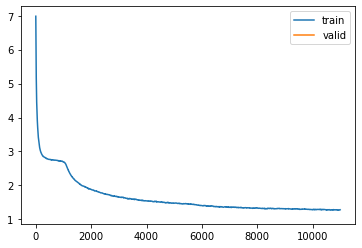

In [ ]:
learn.recorder.plot_loss()